## Introduction to PyMC3

### An example with Linear Regression

In [20]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import graphviz

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [21]:
from pymc3 import Model, Normal, HalfNormal
from pymc3 import find_MAP

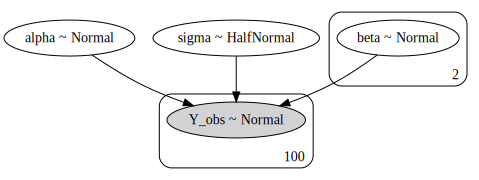

In [22]:
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2 # Deterministic variable, if we don't have this statement
                                         # PyMC3 will not store mu as a value in the trace

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

pm.model_to_graphviz(basic_model)

In [ ]:
map_estimate = find_MAP(model=basic_model)
map_estimate

In [ ]:
from pymc3 import NUTS, sample
from scipy import optimize

In [ ]:
with basic_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = NUTS(scaling=start)

    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

In [ ]:
trace['alpha']

In [ ]:
from pymc3 import traceplot

In [ ]:
traceplot(trace)

In [ ]:
az.summary(trace)

In [ ]:
from pymc3 import summary
summary(trace)

Plot the posterior of the beta distribution with the set parameters and a credible interval for the Highest-Posterior Density which is the interval that has the given probability indicated by the HPD. 

What is the probability of getting a value given by x, we can't really calculate this exactly but we can compute this probability within a range  x + deltax, x - deltax. 

Here, instead of looking at the probability that x = 0.5, we look at the probability that it falls within the range 0.45 and 0.55 called the Region of Practical Equivalence or ROPE

ROPE allows us to make inferences about an event. If we suspect that the dice used at a casino is loaded, we can infer the probability of getting the value 3 from the six outcomes. Ideally, this should be 1/6 = 0.16666, however after computing the posterior our ROPE given by say 0.12 and 0.20 can either overlap with the HPD from the posterior density of the 3 completely, not overlap at all, partially overlap with the HPD. Complete overlap suggests that our computed probability coincides with what we would expect from a fair dice. If it does not overlap, it is not a fair dice and a partial overlap indicates that we cannot be certain that is either fair or unfair.

In [ ]:
import numpy as np
from scipy import stats as stats 

np.random.seed(1)

az.plot_posterior({'θ':stats.beta.rvs(5, 5, size=20000)}, \
                  credible_interval=0.75, \
                  rope =[0.45, 0.55])

Another way to do this is by plotting a reference value on the posterior.

In [ ]:
az.plot_posterior({'θ':stats.beta.rvs(5, 5, size=20000)}, \
                  credible_interval=0.75, \
                  ref_val=0.5)

### Modeling with a Gaussian distribution

ADD DETAIL HERE

Gaussians are normally used to approximate a lot of practical data distributions. 

We read the chemical shifts data, and plot the density to getan idea of 
the data distribution. It looks somewhat like a Gaussian so maybe we can start
there. We have two parameters that is the mean and the standard deviation. 
We can estimate a prior for the mean by looking at the density and putting 
some bounds using a uniform prior. The standard deviation is however chosen to 
have a mean-centered half-normal prior - half-normal since the standard deviation 
cannot be negative. We can provide a hyperparameter for this by insoecting the
density again. These values decide how well we converge to a solution so good 
values are essential for good results. 



([<matplotlib.axis.YTick at 0x7f8862d9b610>],
 <a list of 1 Text major ticklabel objects>)

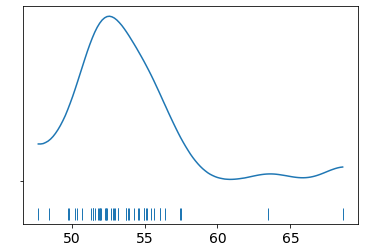

In [24]:
data = np.loadtxt('chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1572.01draws/s]
The acceptance probability does not match the target. It is 0.8804002195405131, but should be close to 0.8. Try to increase the number of tuning steps.


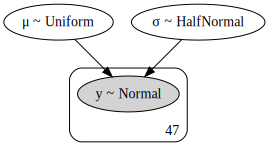

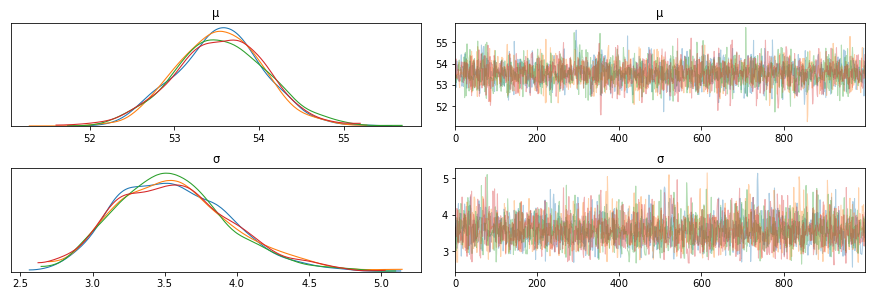

In [26]:
import pymc3 as pm
model_g = Model()

with model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

az.plot_trace(trace_g)
pm.model_to_graphviz(model_g)    

In [ ]:
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [ ]:
az.summary(trace_g)

We can draw samples from the inferred posterior distribution to check to see how they line up with the observed values. Below, we draw 100 samples from this posterior. You are returned a dictionary for each of the observed variables in the model.

You can plot the dsitribution of these samples by passing this variable 'y_pred_g' as shown below. Setting mean=True in the call to plot_ppc computes the mean of the drawn samples and plots it as well.

Two things can be noted here, the mean of the predicted samples is close to the observed adta but the mean of this mean sample is slightly shifted to the right. Also, the variance of the samples; whether we can say qualitatively that this is acceptable or not depends on the problem. In general, the more representative data points available to us, the lower the variance.

Another thing to note here is that we modeled this using a Gaussian, however we have some outliers that need to be accoutned for which we cannot do well with a Gaussian distribution. 

In [ ]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)
y_pred_g

In [ ]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
ax[0].legend(fontsize=15)

### Robust models with a Student's t distribution

ADD DETAIL HERE

μ corresponds to the mean of the distribution

σ is the scale and corresponds to the standard deviation

ν is the degrees of freedom and takes between 0 and $\infty$. A value of 1 corresponds to the Cauchy distribution and indicates heavy tails, while infinty corresponds to a Gaussian.

In [ ]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75) # mean
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.plot_trace(trace_t)

In [ ]:
# Using a student's t distribution we notice that the outliers are captured more 
# accurately now and the model fits better
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=True)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)

### Hierarchical models

Suppose we want to perform an analysis of water quality in a state and we divide this state into districts, there are two options to do this, study each district separately - we lose information especially if there is insufficient data for some districts. But we get a more detailed model per district.

The second option is to combine all the data and estimate the water quality of the state as a whole - More data but we lose granular information about each district.

The hierarchical model combines both of these options, by sharing information between the districts using hyperpriors that are priors over the parameter priors. In other words, instead of setting the parameter priors to a constant value, we draw it from another prior distribution called the hyperprior. This hyperprior is shared among all the districts and as a result sharing information between them.

In [ ]:
# We measure the water samples for three districts, and we collect 30 samples 
# for each district. We count the number of samples that have contamination
# below the acceptable levels
N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [18, 18, 18] # Number of samples with water contamination 
                         # below accepted levels
# Create an id for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))


In [ ]:
group_idx

In [ ]:
data

The process of generating our samples looks like the following. First we set the parameters for the prior or the hyperpriors.

ADD DETAIL HERE

$ \mu \sim Beta(\alpha_p, \beta_p)  \\
  k \sim | Normal(0,\sigma_k) | \\
  \alpha =  \mu * k \\
  \beta = (1 - \mu) * k \\
$

These parameters are then used to define the priors. This is different from using a constant prior value as we saw before.

$
  \theta_i \sim Beta(\alpha_i, \beta_i) \\
  y_i \sim Bern(\theta_i)
$



In [ ]:
def get_hyperprior_model(data, N_samples, group_idx):
    with pm.Model() as model_h:
        μ = pm.Beta('μ', 1., 1.) # hyperprior
        κ = pm.HalfNormal('κ', 10) # hyperprior
        θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples)) # prior
        y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
        trace_h = pm.sample(2000)
    az.plot_trace(trace_h)
    print(az.summary(trace_h))
    
get_hyperprior_model(data, N_samples, group_idx)

In [ ]:
# Shrinkage - information is shared among the subgroups so we move away from extremes, which is great if
# we have outliers in our data subgroups especially when we do not have a lot of data - ADD DETAIL HERE

N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [5, 5, 5] # Number of samples with water contamination 
                         # below accepted levels
# Create an id for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

get_hyperprior_model(data, N_samples, group_idx)

In [ ]:
N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [18, 5, 5] # Number of samples with water contamination 
                         # below accepted levels
# Create an id for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

get_hyperprior_model(data, N_samples, group_idx)

Repeat the above with a constant prior instead of hyperpriors

In [ ]:
N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [18, 18, 1] # Number of samples with water contamination 
                         # below accepted levels
# Create an id for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

get_hyperprior_model(data, N_samples, group_idx)

### Linear Regression

In [ ]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()


import pymc3 as pm

with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_g = pm.sample(2000, tune=1000)
    
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'])
plt.figure()
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})
plt.figure()
plt.plot(x, y, 'C0.')
alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()
draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]
         * x[:, np.newaxis], c='gray', alpha=0.5)
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

#### We sample from the posterior

ppc = pm.sample_posterior_predictive(trace_g,
                                     samples=2000,
                                     model=model_g)

plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray')

Looking at the plot of $\alpha$ and $\beta$, one can notice the high degree of correlation berween these two variables. This results in a paramete posterior space that is diagonally shaped, which is problematic for many samplers such as the Metropolis-Hastings MCMC sampler. One recommended approach to minimize this correlation is to center the independednt variables.

$\tilde{x} = x - \bar{x}$

The advantage of this is twofold

1. The pivot point is the intercept when the slope changes
2. The parameter posterior space is more circular

In order to center the data

$y = \alpha - \beta x$
can be reformulated as 

$y = \alpha - \tilde{\beta}(x - \bar{x})$ = $\alpha + \tilde{\beta} \bar{x} - \tilde{\beta} x$

$y = \tilde{\alpha} - \tilde{\beta} x$

which implies that the original alpha can now be recovered using the formula

$\alpha = \tilde{\alpha} - \tilde{\beta} \bar{x}$

You can also standardize the data by mean centering and dividing by the standard deviation

$\tilde{x} = (x - \bar{x}) / \sigma_x$

In [ ]:
import seaborn as sns

# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")
df

In [ ]:
# Plot the 4 subgroups in the data

x_0 = df[df.dataset == 'I']['x'].values
y_0 = df[df.dataset == 'I']['y'].values
x_1 = df[df.dataset == 'II']['x'].values
y_1 = df[df.dataset == 'II']['y'].values
x_2 = df[df.dataset == 'III']['x'].values
y_2 = df[df.dataset == 'III']['y'].values
x_3 = df[df.dataset == 'IV']['x'].values
y_3 = df[df.dataset == 'IV']['y'].values
_, ax = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)

ax = np.ravel(ax)
ax[0].scatter(x_0, y_0)
ax[0].set_title('Group I')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0, labelpad=15)
ax[1].scatter(x_1, y_1)
ax[1].set_title('Group II')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y', rotation=0, labelpad=15)
ax[2].scatter(x_2, y_2)
ax[2].set_title('Group III')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y', rotation=0, labelpad=15)
ax[3].scatter(x_3, y_3)
ax[3].set_title('Group IV')
ax[3].set_xlabel('x')
ax[3].set_ylabel('y', rotation=0, labelpad=15)

In [ ]:
# Plot data group 3 and its Kernel density

x_2 = x_2 - x_2.mean()
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_2, y_2)[:2]
ax[0].plot(x_2, (alpha_c + beta_c * x_2), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_2, y_2, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_2, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

In [ ]:
# Use PyMC3 to model this Linear Regression using a Student's t distribution
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    y_pred = pm.StudentT('y_pred', mu=α + β * x_2,
                         sd=ϵ, nu=ν, observed=y_2)
    trace_t = pm.sample(2000)
    
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_2, alpha_m + beta_m * x_2, c='k', label='robust')
plt.plot(x_2, y_2, '*')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

### Hierarchical Linear Regression

In this example, we create 8 subgroups with 7 of them having 20 data points and the last one having a single data point. This is to illustrate the importance of imbalanced subgroups with sparse data. 

The data for the 8 groups are generated from a normal distribution of mean 10 and a standard deviation of 1. The parameters for the linear model are generated from normal and beta dsitributions.

In [ ]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)

np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M) 
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
print("Alpha parameters ", alpha_real )

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(12,8), sharex=True, sharey=True)

ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)     
    j += N
    k += N
plt.tight_layout()

#### We build a non-hierarchical model first

Note how the obtained $\alpha$ and $\beta$ values vary for each group, particularly the last one which is really off.

In [ ]:
# Center the data
x_centered = x_m - x_m.mean()

with pm.Model() as unpooled_model:
    # Note the M prior parameters for the M groups
    α_tmp = pm.Normal('α_tmp', mu=2, sd=5, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)
    # Rescale alpha back - after x had been centered the computed alpha is different from the original alpha
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    trace_up = pm.sample(2000)

az.plot_trace(trace_up)
plt.figure()
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)
az.summary(trace_up)

In [ ]:
with pm.Model() as hierarchical_model:
    # Hyperpriors - we add these instead of setting the prior values to a constant
    # Note that there exists only one hyperprior  for all M groups, shared hyperprior
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=100, sd=1) # try changing these hyperparameters
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10) # try changing these hyperparameters
    β_μ = pm.Normal('β_μ', mu=10, sd=2) # reasonable changes do not have an impact
    β_σ = pm.HalfNormal('β_σ', sd=5)
    
    # priors - note that the prior parameters are no longer a constant
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    y_pred = pm.StudentT('y_pred',
                         mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ *
                           x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())
    trace_hm = pm.sample(1000)

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N



### Polynomial Regression for nonlinear data

In [ ]:
x_1_centered = x_1 - x_1.mean()
plt.scatter(x_1_centered, y_1)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

plt.figure()
x_0_centered = x_0 - x_0.mean()
plt.scatter(x_0_centered, y_0)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [ ]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_1.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    mu = α + β1 * x_1_centered + β2 * x_1_centered**2
    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_1)
    trace = pm.sample(2000)

In [ ]:
x_p = np.linspace(-6, 6)
y_p = trace['α'].mean() + trace['β1'].mean() * x_p + trace['β2'].mean() * x_p**2
plt.scatter(x_1_centered, y_1)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')


In [ ]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_0.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    mu = α + β1 * x_0_centered + β2 * x_0_centered**2
    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_0)
    trace = pm.sample(2000)

In [ ]:
x_p = np.linspace(-6, 6)
y_p = trace['α'].mean() + trace['β1'].mean() * x_p + trace['β2'].mean() * x_p**2
plt.scatter(x_0_centered, y_0)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')

### Multiple Linear Regression

In [ ]:
np.random.seed(314)

# N is the total number of observations 
N = 100
# m is 2, the number of independent variables
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

# X is # n x m
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T 
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [ ]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)

In [ ]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α_tmp + pm.math.dot(X_centered, β)
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace = pm.sample(2000)

az.summary(trace)

### Logistic Regression

While everything we have seen so far involved regression, the same ideas can be applied to a classification task as well. We use the logistic regression model to perform this classification here. The name 'regression' is due to the fact that the model outputs class probabilities as numbers which is then converted into classes using a decision boundary. There are many ways to select an appropriate decision boundary, many of which is covered in the section for model selection.

#### Inverse Link function

At this point it is a good idea to bring up the concept of a inverse link function, which takes the form

$\theta = f(\alpha + \beta x)$

Here 'f' is called the inverse link function, the term inverse refers to the fact that the function is applied to the right hand side of the equation. In a linear regression, this inverse link function is the identity function. In the case of a lienar regression model, the value 'y' at any point 'x' is modeled as the mean of a Gaussian distribution centered at the point (x,y). The error as a result of the true 'y' and the estimated 'y' as modeled with the standard deviation of this Gaussian at that point (x,y). Now think about the scenario where this is not appropriately modeled using a Gaussian. A classification problem is a perfect example of such a scenario where the discrete classes are not modeled well as a Gaussian and hence we can't use a Gaussian to model the mean of those classes. As a result, we would like to convert the output of $\alpha = \beta x$ to some other range of values that are more appropriate to the distribution being modeled, which is what the link function intends to do.

#### Logistic function

The logistic function is defined as the function

$logistic(x) = \dfrac{1}{1 + \exp{(-x)}}$

This is also called the sigmoid function and it restricts value to the range [0,1]

In [ ]:
x = np.linspace(-5,5)
plt.plot(x, 1 / (1 + np.exp(-x)))
plt.xlabel('x')
plt.ylabel('logistic(x)')



#### Example using the Iris data

The simplest example using a logistic regression model is one that can be used to identify two classes. If you are given a set of independent variables that are features which correspond to an output dependent variable that is a class, you can build a model to learn the relationship between the features and the output classes. This is done with the help of the logistic function which acts as the inverse link function to relate the features to the output class. 

$\theta = logistic(\alpha + \beta x)$

$y = Bern(\theta)$

Here the binary class probability is drawn from a Bernoulli distribution, but the mean parameter $\theta$ is now given by the regression equation $logistic(\alpha + \beta x)$. In regular linear regression, this parameter was drawn from a Gaussian distribution. Also, in the case of the coin-flip example where we use a Bernoulli distribution, the parameter $\theta$ was drawn from a Beta prior distribution however here we have output classes associated with every observation and hence can be posed as a regression problem.

We load the iris data from scikit learn and plot the distribution of the three classes for two of the features. We also perform a pairplot to visualize the correlation of each feature with every other feature. The diagonal of this plot shows the distribution of the three classes for that feature.


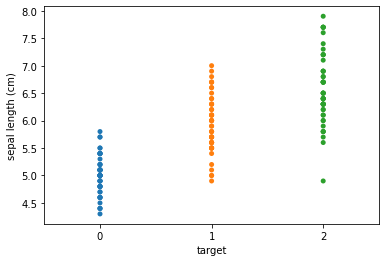

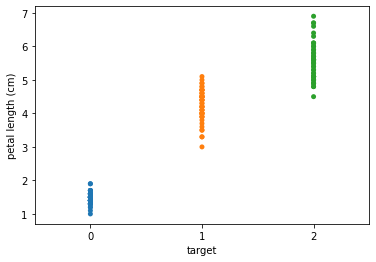

<Figure size 432x288 with 0 Axes>

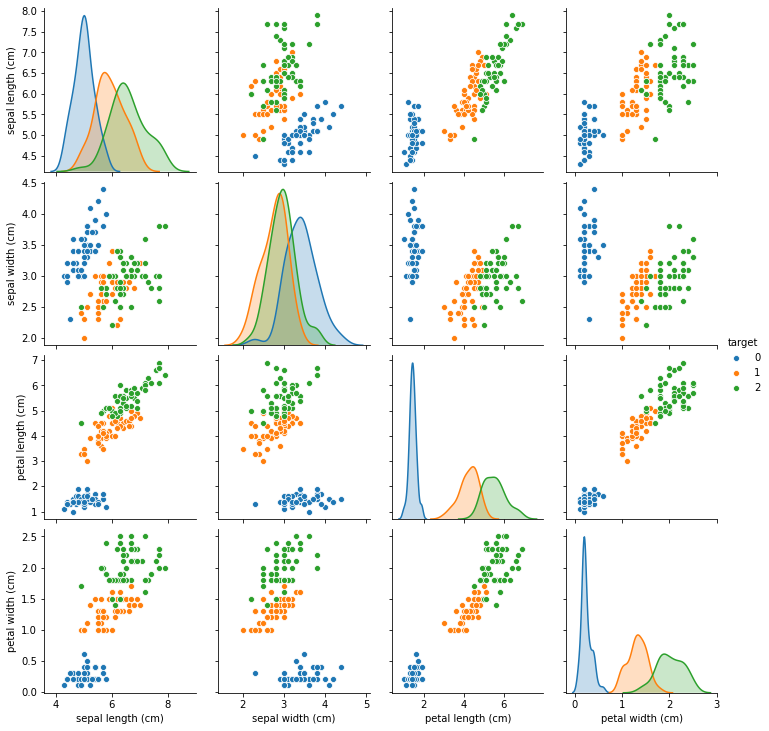

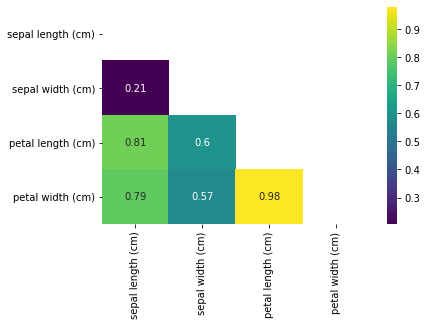

In [4]:
import sklearn
import graphviz
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
from sklearn import datasets
df = datasets.load_iris()
iris_data = pd.DataFrame(df['data'], columns=df['feature_names'])
iris_data['target'] = df['target']
seaborn.stripplot(x='target', y='sepal length (cm)', data=iris_data, jitter=False)
plt.figure()
seaborn.stripplot(x='target', y='petal length (cm)', data=iris_data, jitter=False)
plt.figure()
seaborn.pairplot(iris_data, hue='target', diag_kind='kde')
plt.figure()
corr = iris_data.query("target == (0,1)").loc[:, iris_data.columns != 'target'].corr() 
mask = np.tri(*corr.shape).T 
seaborn.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')

In [ ]:
df['target_names']

In [10]:
# Select the first two classes for a binary classification problem
df = iris_data.query("target == (0,1)")
y_0 = df.target
x_n = 'sepal length (cm)' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()


In [11]:
import pymc3 as pm
import arviz as az

with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    trace_0 = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1496.45draws/s]


In [12]:
az.summary(trace_0, var_names=["α","β","bd"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.315,0.347,-0.354,0.932,0.007,0.006,2758.0,1748.0,2815.0,2159.0,1.0
β,5.396,1.070,3.537,7.445,0.022,0.016,2445.0,2305.0,2518.0,2211.0,1.0
bd,-0.057,0.064,-0.174,0.061,0.001,0.001,2844.0,1960.0,2723.0,2370.0,1.0


([<matplotlib.axis.XTick at 0x7f8862d93d90>,
 [Text(0, 0, '4.0'),
  Text(0, 0, '4.5'),
  Text(0, 0, '5.0'),
  Text(0, 0, '5.5'),
  Text(0, 0, '6.0'),
  Text(0, 0, '6.5'),
  Text(0, 0, '7.0'),
  Text(0, 0, '7.5')])

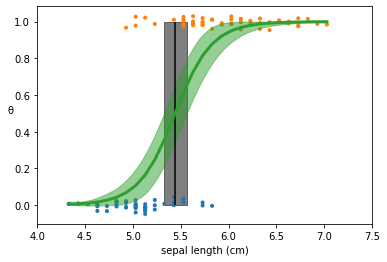

In [13]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hpd(x_c, trace_0['θ'], color='C2')
plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

In this case, the decision boundary is defined to be the value of 'x' when 'y' = 0.5. This turns out to be $-\alpha / \beta$. However, this value was chosen under the assumption that the midpoint of the class values are a good candidate, but this does not have to be the case.

#### Multiple Logistic Regression

The above example with a single feature can be expanded to take multiple features or independent variables.

In [14]:
# Select the first two classes for a binary classification problem
df = iris_data.query("target == (0,1)")
y_0 = df.target
x_n = ['sepal length (cm)', 'sepal width (cm)']
# Center the data by subtracting the mean from both columns
df_c = df - df.mean() 
x_c = df_c[x_n].values
print(x_c)

[[-3.710e-01  4.010e-01]
 [-5.710e-01 -9.900e-02]
 [-7.710e-01  1.010e-01]
 [-8.710e-01  1.000e-03]
 [-4.710e-01  5.010e-01]
 [-7.100e-02  8.010e-01]
 [-8.710e-01  3.010e-01]
 [-4.710e-01  3.010e-01]
 [-1.071e+00 -1.990e-01]
 [-5.710e-01  1.000e-03]
 [-7.100e-02  6.010e-01]
 [-6.710e-01  3.010e-01]
 [-6.710e-01 -9.900e-02]
 [-1.171e+00 -9.900e-02]
 [ 3.290e-01  9.010e-01]
 [ 2.290e-01  1.301e+00]
 [-7.100e-02  8.010e-01]
 [-3.710e-01  4.010e-01]
 [ 2.290e-01  7.010e-01]
 [-3.710e-01  7.010e-01]
 [-7.100e-02  3.010e-01]
 [-3.710e-01  6.010e-01]
 [-8.710e-01  5.010e-01]
 [-3.710e-01  2.010e-01]
 [-6.710e-01  3.010e-01]
 [-4.710e-01 -9.900e-02]
 [-4.710e-01  3.010e-01]
 [-2.710e-01  4.010e-01]
 [-2.710e-01  3.010e-01]
 [-7.710e-01  1.010e-01]
 [-6.710e-01  1.000e-03]
 [-7.100e-02  3.010e-01]
 [-2.710e-01  1.001e+00]
 [ 2.900e-02  1.101e+00]
 [-5.710e-01  1.000e-03]
 [-4.710e-01  1.010e-01]
 [ 2.900e-02  4.010e-01]
 [-5.710e-01  5.010e-01]
 [-1.071e+00 -9.900e-02]
 [-3.710e-01  3.010e-01]



As we saw before, the equation for multiple logistic regression relating the $\theta$ parameter to the features can be written as 

$\theta = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2)$

$y = Bern(\theta)$

This gives us a decision boundary, assuming y = 0.5, of 

$x = -\dfrac{\alpha}{\beta_2} - \dfrac{\beta_1}{\beta_2} x_1$ 

Unlike the previous equation, this one represents a line for the variables x1 and x2 which separates the two-dimensional space occupied by x1 and x2. For higher dimensions, this boundary decision will be a hyperplane of dimension 'n-1' for a feature space of dimension 'n'.

In [15]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
    μ = α + pm.math.dot(x_c, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_c[:,0])
    yl = pm.Bernoulli('yl', p=θ, observed=y_0) 
    trace_0 = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:05<00:00, 1969.48draws/s]


Text(0, 0.5, 'sepal width (cm)')

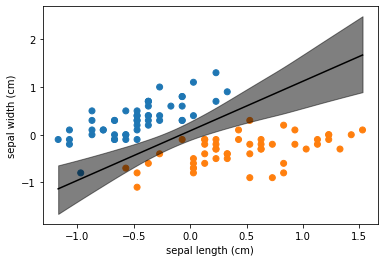

In [16]:
# We plot the HPD on the centered data, we have not scaled it back to the oroginal range
idx = np.argsort(x_c[:,0]) 
bd = trace_0['bd'].mean(0)[idx] 
plt.scatter(x_c[:,0], x_c[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_c[:,0][idx], bd, color='k'); 
az.plot_hpd(x_c[:,0], trace_0['bd'], color='k')
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

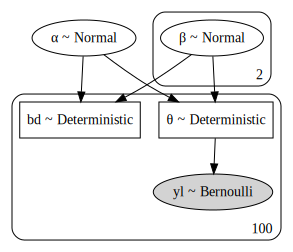

In [19]:
pm.model_to_graphviz(model_1)